# CONCEPT 

- Simple하게 하나의 모델로 전체 학습하도록
- 변수를 제거해가며 진행

# STEP 01

In [63]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import gc
import math
import random
import pickle
import pandas as pd
import numpy as np
import multiprocessing
from tqdm.auto import tqdm

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, sampler

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN

import shap
import catboost

In [2]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')              
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      262 non-null    object
 1   father  262 non-null    int64 
 2   mother  262 non-null    int64 
 3   gender  262 non-null    int64 
 4   trait   262 non-null    int64 
 5   SNP_01  262 non-null    object
 6   SNP_02  262 non-null    object
 7   SNP_03  262 non-null    object
 8   SNP_04  262 non-null    object
 9   SNP_05  262 non-null    object
 10  SNP_06  262 non-null    object
 11  SNP_07  262 non-null    object
 12  SNP_08  262 non-null    object
 13  SNP_09  262 non-null    object
 14  SNP_10  262 non-null    object
 15  SNP_11  262 non-null    object
 16  SNP_12  262 non-null    object
 17  SNP_13  262 non-null    object
 18  SNP_14  262 non-null    object
 19  SNP_15  262 non-null    object
 20  class   262 non-null    object
dtypes: int64(4), object(17)
memory usage: 43.1+ KB


In [4]:
df_train['class'].value_counts()

B    114
C     79
A     69
Name: class, dtype: int64

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      175 non-null    object
 1   father  175 non-null    int64 
 2   mother  175 non-null    int64 
 3   gender  175 non-null    int64 
 4   trait   175 non-null    int64 
 5   SNP_01  175 non-null    object
 6   SNP_02  175 non-null    object
 7   SNP_03  175 non-null    object
 8   SNP_04  175 non-null    object
 9   SNP_05  175 non-null    object
 10  SNP_06  175 non-null    object
 11  SNP_07  175 non-null    object
 12  SNP_08  175 non-null    object
 13  SNP_09  175 non-null    object
 14  SNP_10  175 non-null    object
 15  SNP_11  175 non-null    object
 16  SNP_12  175 non-null    object
 17  SNP_13  175 non-null    object
 18  SNP_14  175 non-null    object
 19  SNP_15  175 non-null    object
dtypes: int64(4), object(16)
memory usage: 27.5+ KB


In [6]:
df_train.describe()

,father,mother,gender,trait
count,262.0,262.0,262.0,262.000000
mean,0.0,0.0,0.0,1.736641
std,0.0,0.0,0.0,0.441298
min,0.0,0.0,0.0,1.000000
25%,0.0,0.0,0.0,1.000000
50%,0.0,0.0,0.0,2.000000
75%,0.0,0.0,0.0,2.000000
max,0.0,0.0,0.0,2.000000


In [7]:
df_test.describe()

,father,mother,gender,trait
count,175.0,175.0,175.0,175.000000
mean,0.0,0.0,0.0,1.708571
std,0.0,0.0,0.0,0.455724
min,0.0,0.0,0.0,1.000000
25%,0.0,0.0,0.0,1.000000
50%,0.0,0.0,0.0,2.000000
75%,0.0,0.0,0.0,2.000000
max,0.0,0.0,0.0,2.000000


In [212]:
# trait와 Label A의 상관계수가 1로, 다른 변수에 대한 영향력이 학습되지 않을 정도로 높으므로 배제해보고 진행
df_train2 = df_train.drop(columns=['father', 'mother', 'gender','trait', 'SNP_04', 'SNP_01'])
df_test2 = df_test.drop(columns=['father', 'mother', 'gender', 'trait', 'SNP_04', 'SNP_01'])

strategy1 = {'A':1000, 'B':1000, 'C':1000}
smote1 = SMOTEN(sampling_strategy=strategy1, k_neighbors=50)
strategy2 = {'A':1000, 'B':1000, 'C':1100}
smote2 = SMOTEN(sampling_strategy=strategy2, k_neighbors=50)
X, y = df_train2.iloc[:, 1:-1], (df_train2['class'].values )
X2, y2 = smote1.fit_resample(X, y)
X3, y3 = smote2.fit_resample(X, y)

In [213]:
def catgbmc(inputX, inputY, validX, validY, params) :  
    var_categ = inputX.columns.tolist()
    model = CatBoostClassifier(
        cat_features=var_categ,
        **params,
        task_type='GPU',
        devices='0',
        )
  
    model.fit(
        inputX, inputY,
        eval_set=(inputX, inputY)
        );     

    pred = model.predict(validX)
    score = f1_score(validY, pred, average='macro')
    print(score)
    
    return model

In [214]:
params = {'iterations':1000,
          'learning_rate':0.1,
          # 'l2_leaf_reg' : 10,
          # 'grow_policy' : 'Lossguide',
          'verbose':0,
          'random_seed':0}

model1 = catgbmc(X2, y2, X, y, params)
model2 = catgbmc(X3, y3, X, y, params)

1.0
1.0


In [215]:
pd.DataFrame(data=model1.get_feature_importance(), index=model1.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
SNP_11,66.121133
SNP_08,8.084872
SNP_05,5.471976
SNP_02,5.310721
SNP_15,3.510609
SNP_10,3.100119
SNP_13,2.505559
SNP_03,1.932633
SNP_07,1.767096
SNP_06,1.187325


In [216]:
pd.DataFrame(data=model2.get_feature_importance(), index=model2.feature_names_, columns=['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
SNP_11,67.232553
SNP_05,8.011599
SNP_08,7.529667
SNP_02,6.825513
SNP_15,2.477000
SNP_10,1.942005
SNP_06,1.213447
SNP_03,1.140276
SNP_14,1.104637
SNP_07,0.949041


In [217]:
def show_shap(model) :        
    # Use a KernelExplainer since catboost is not yet supported by TreeExplainer
    explainer = shap.KernelExplainer(model.predict_proba, X)
    #shap_values = explainer.shap_values(X_train) # does not work with current shap version if using a catboost classifier
    shap_values = model.get_feature_importance(catboost.Pool(X, y, cat_features=[x for x in range(X.shape[1])]), type=catboost.EFstrType.ShapValues)  # can use 'ShapValues' instead for the type, and categorical_columns is the list of the columns names where the values are categorical

    # visualize the first prediction's explanation
    shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=X.columns, out_names=list(df_train2['class'].unique()))

    # summarize the effects of all the features in a multi-class barplot
    original_shape = shap_values.shape
    shap_values_reshaped = shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
    shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=X, class_names=df_train2['class'].unique(), plot_type='bar')

Using 262 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


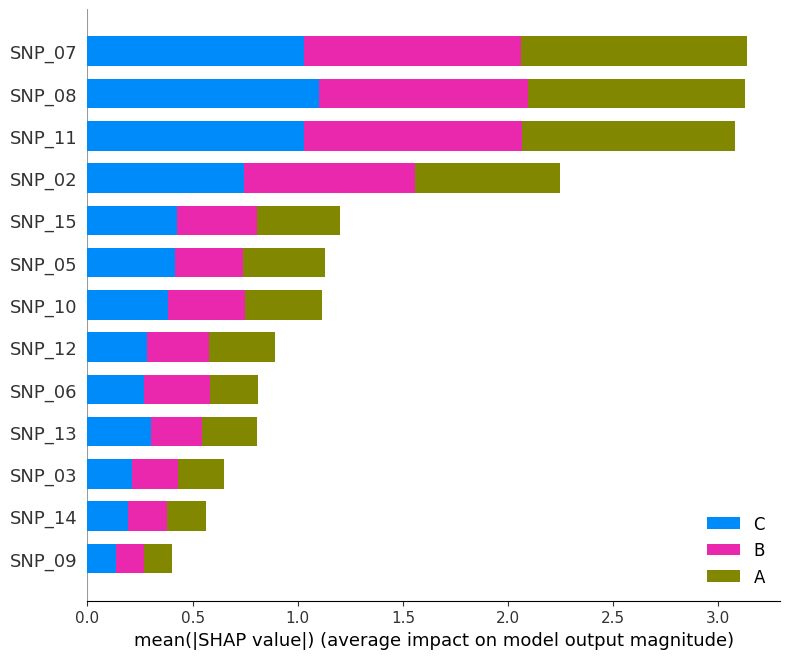

In [218]:
show_shap(model1)

Using 262 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


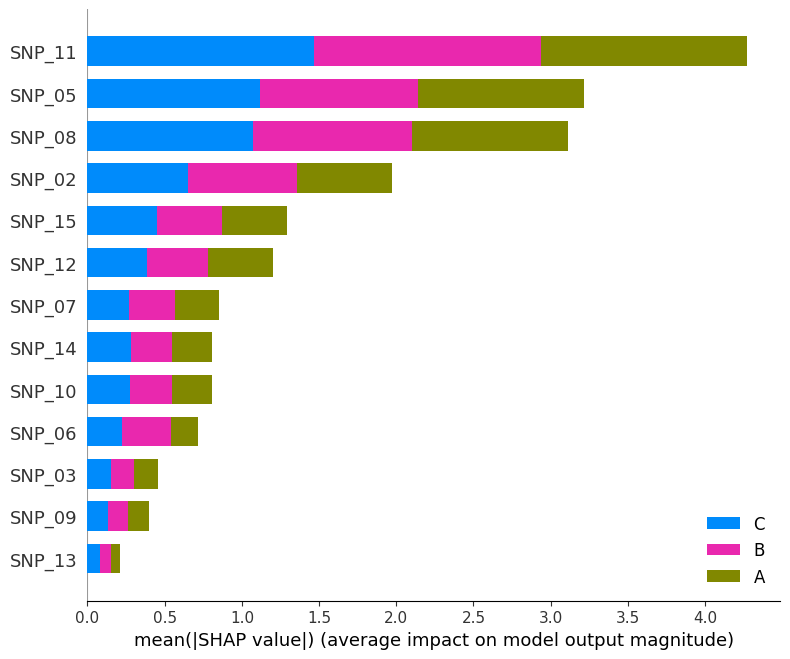

In [219]:
show_shap(model2)

In [220]:
pred = model1.predict(X)
score = f1_score(y, pred, average='macro')
print(score) 

1.0


In [221]:
pred = model2.predict(X)
score = f1_score(y, pred, average='macro')
print(score) 

1.0


In [222]:
pred1 = model1.predict(df_test2.iloc[:, 1:])
pred2 = model2.predict(df_test2.iloc[:, 1:])
np.sum(pred1 != pred2)

14

In [223]:
pred3 = model1.predict_proba(df_test2.iloc[:, 1:])
pred4 = model2.predict_proba(df_test2.iloc[:, 1:])

pred5 = np.argmax((pred3+pred4) / 2, axis=1)
pred5

array([0, 1, 2, 1, 0, 1, 2, 2, 0, 0, 2, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 2, 1, 1, 2, 0, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 2, 2, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0,
       1, 1, 1, 2, 0, 0, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 2, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1])

In [224]:
df = pd.DataFrame()
df['pred1'] = pd.Series(pred1.flatten())
df['pred2'] = pd.Series(pred2.flatten())
df['high1'] = pd.read_csv('submit_high1.csv')['class']
df['high2'] = pd.read_csv('submit_high2.csv')['class']
df['pred5'] = pd.Series(pred5)
df[df.pred1 != df.pred2]

,pred1,pred2,high1,high2,pred5
7,C,B,B,B,2
17,C,B,B,B,2
56,C,B,C,C,2
58,C,B,B,B,1
60,C,A,A,A,2
74,C,B,C,C,1
85,B,C,B,B,1
110,C,B,C,C,1
117,C,B,C,C,1
119,C,B,C,C,2


In [225]:
df[df.pred1 != df.high1]

,pred1,pred2,high1,high2,pred5
3,B,B,C,C,1
5,B,B,C,C,1
7,C,B,B,B,2
12,C,C,B,C,2
17,C,B,B,B,2
19,B,B,C,C,1
35,C,C,B,B,2
58,C,B,B,B,1
60,C,A,A,A,2
66,A,A,B,B,0


In [226]:
df.pred1.value_counts()

B    77
A    51
C    47
Name: pred1, dtype: int64

In [227]:
df.pred2.value_counts()

B    87
A    51
C    37
Name: pred2, dtype: int64

In [228]:
df.high1.value_counts()

B    84
A    51
C    40
Name: high1, dtype: int64

In [229]:
df.high2.value_counts()

B    82
A    51
C    42
Name: high2, dtype: int64

In [230]:
df_train['class'].value_counts() / len(df_train) * len(df_test)

B    76.145038
C    52.767176
A    46.087786
Name: class, dtype: float64

In [168]:
# A : 45, B : 78, C: 42
b_len = 129
answer = np.zeros(175)
answer[45:45+b_len] = 1
answer[45+b_len:] = 2

submit = np.zeros(175)

# submit = answer.copy()
# submit[-1:]=0
# submit[45:45+1]=0

f1_score(answer, submit, average='macro'), f1_score(answer, submit, average='micro')

(0.13636363636363635, 0.2571428571428571)

In [250]:
# A : 45, B : 78, C: 42
b_len = 129
answer = np.ones(175)
answer[45:] = 0
# answer[45+b_len:] = 2

submit = np.ones(175)
submit[51:] = 0

f1_score(answer, submit)

0.9375

In [233]:
f1_score(answer, submit, average='macro') / 3

0.14207650273224046

In [188]:
45/130

0.34615384615384615